# Mask separator

tackling the problem of artifacts in the masks and separating the masked regions to L/R lung.

Example ( A416909 ): 
![alt text](images/figures/masks_example.png)

(512, 512, 4)
0.08322274509803922 0.8690803921568628
nr contours:  5


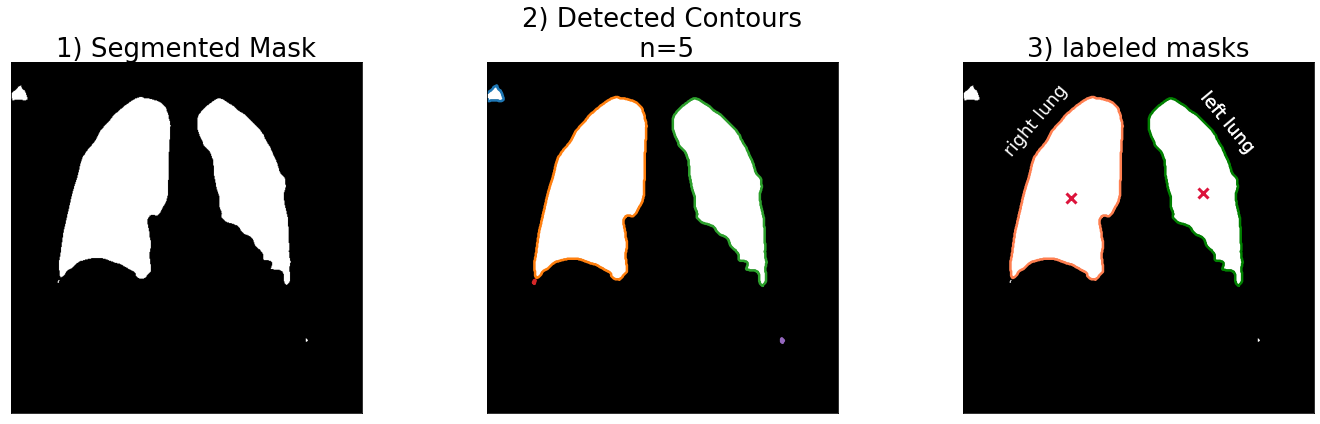

In [5]:
import numpy as np
from skimage.io import imread
from skimage.draw import polygon
#from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray, rgba2rgb
from skimage import measure
import random

import matplotlib.pyplot as plt


image = imread("/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A416909/02-20-1901-NA-CHEST AP PORT-36142/1.000000-AP-08564/1-1_mask.png")
print(image.shape)
image_gray = rgb2gray(rgba2rgb(image))
print(image_gray.min(), image_gray.max())
image_gray = (image_gray > image_gray.min()).astype(int) # binarize grayscale

# Find contours at a constant value of 0.8
contours = measure.find_contours(image_gray, image_gray.min())
print("nr contours: ", len(contours))

# Display the image and plot all contours found
fig, ax = plt.subplots(1,3, figsize=(20,6))
# raw image
ax[0].imshow(image_gray, cmap="gray")

ax[1].imshow(image_gray, cmap=plt.cm.gray)

for contour in contours:
    ax[1].plot(contour[:, 1], contour[:, 0], linewidth=2.5)

## center estimation
d = {}
for i, cont in enumerate(contours):
    d[len(cont)] = i
biggest = sorted(d.keys())[-2:]
biggest_c = [d[i] for i in biggest]

ax[2].imshow(image_gray, cmap=plt.cm.gray)

cnt = 0
for i, col in zip(biggest_c, ["green", "coral"]):
    cont = contours[i]
    ax[2].plot(cont[:, 1], cont[:, 0], linewidth=2.5, color=col)
    cont_center_x = cont[:, 1].mean()
    cont_center_y = cont[:, 0].mean()
    ax[2].plot(cont_center_x, cont_center_y, marker="x", color="crimson", markersize=10, markeredgewidth=3)
    if cnt == 0:
        ax[2].text(55, 135, "right lung", rotation="50", fontsize=18, color="w")
        cnt+=1
    if cnt == 1:
        ax[2].text(340, 130,  "left lung", rotation="-50", fontsize=18, color="w")

titles = ["1) Segmented Mask", f"2) Detected Contours\n n={len(contours)}", "3) labeled masks"]
for i in range(3):
    ax[i].axis('image')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(titles[i], size=26)
fig.tight_layout()
fig.savefig("../thesis/figures/impl/mask_cleaning.png")
plt.show()

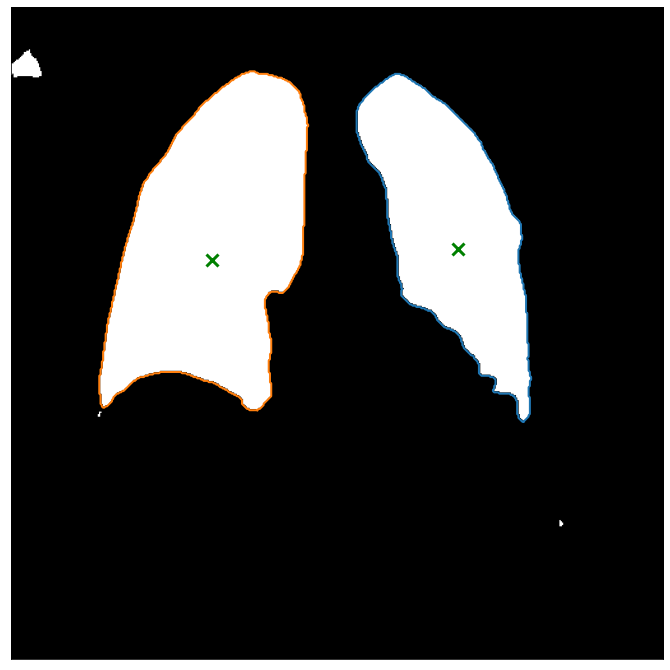

In [2]:
d = {}
for i, cont in enumerate(contours):
    d[len(cont)] = i
biggest = sorted(d.keys())[-2:]
biggest_c = [d[i] for i in biggest]

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(image_gray, cmap=plt.cm.gray)

for i in biggest_c:
    cont = contours[i]
    ax.plot(cont[:, 1], cont[:, 0], linewidth=2)
    cont_center_x = cont[:, 1].mean()
    cont_center_y = cont[:, 0].mean()
    ax.plot(cont_center_x, cont_center_y, "x-g", markersize=12, markeredgewidth=3)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])

plt.show()


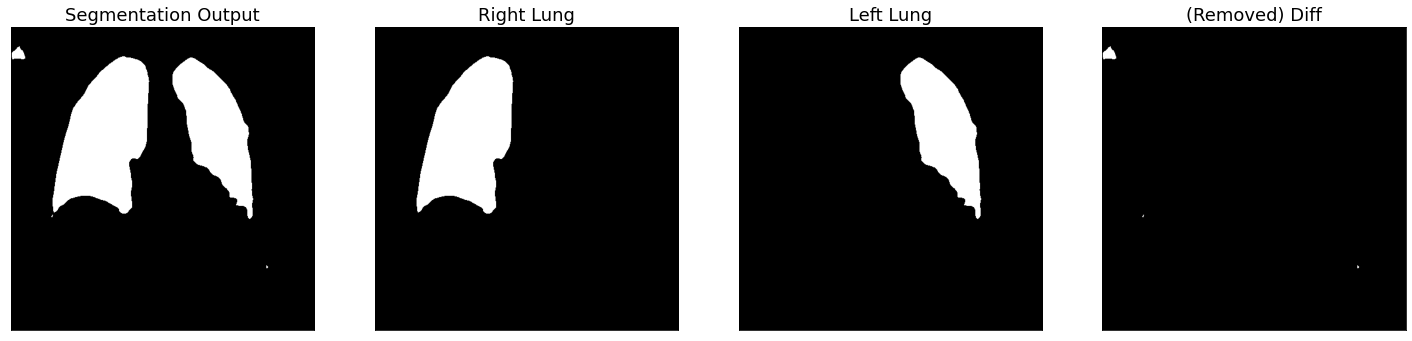

In [3]:
def mask_separator(fpath, debug=False):

    image = imread(fpath)
    image_gray = rgb2gray(rgba2rgb(image))
    image_gray = (image_gray > image_gray.min()).astype(int) # binarize grayscale

    contours = measure.find_contours(image_gray, 0.0001) # using min() value here had bad influences!
    if debug:
        print(fpath)
        print("Nr of contours: ", len(contours))
    d = {}
    for i, cont in enumerate(contours):
        d[len(cont)] = i
    biggest = sorted(d.keys())[-2:]
    biggest_c = [d[i] for i in biggest]

    fig, ax = plt.subplots(1, 4,
     figsize=(25,14)
     )
    ax[0].imshow(image_gray, cmap=plt.cm.gray)
    title = ["Segmentation Output", "Right Lung", "Left Lung", "(Removed) Diff"]
    for i in range(0,4):
        ax[i].set_xticks([]) 
        ax[i].set_yticks([])
        ax[i].set_title(title[i], fontsize=18)

    d = {}
    for cnt, i in enumerate(biggest_c):
        cont = contours[i]
        mask = np.zeros(image_gray.shape)
        rr, cc = polygon(cont[:, 0], cont[:, 1], mask.shape)
        mask[rr, cc] = 1
        d[cnt] = {"mask": mask,
        "center_x": cont[:, 1].mean(), "center_y": cont[:, 0].mean()}

    if d[0]["center_x"] > d[1]["center_x"]:
        mask_l = d[0]["mask"] # left lung is the right one in the image
        mask_r = d[1]["mask"] 
    else:
        mask_r = d[0]["mask"] 
        mask_l = d[1]["mask"] 

    ax[1].imshow(mask_r, cmap="gray")
    ax[2].imshow(mask_l, cmap="gray")

    image_diff = (image_gray - (mask_l + mask_r))
    ax[3].imshow(image_diff, cmap="gray")
fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A416909/02-20-1901-NA-CHEST AP PORT-36142/1.000000-AP-08564/1-1_mask.png"
mask_separator(fpath)

In [38]:
import os
path = "/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/" # old
#path = "/Volumes/Samsung_T5/MA/manifest-1641816674790/testing/"
masks = []
for subdir, dirs, files in os.walk(path):
    for file in files:
            if not file.startswith("._"):
                if file.endswith("_mask.png"):
                    if "1.000000" in subdir:
                        masks.append(os.path.join(subdir,file)) 


In [44]:
import random
random.choices(masks, k=12)

['/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A401125/12-27-1900-NA-CHEST AP VIEWONLY-95577/1.000000-AP-85494/1-1_mask.png',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A416909/02-26-1901-NA-CHEST AP PORT-76147/1.000000-AP-16392/1-1_mask.png',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A751562/01-14-1901-NA-CHEST AP PORT-60468/1.000000-AP-29466/1-1_mask.png',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A099771/01-07-1901-NA-CHEST AP PORT-35147/1.000000-AP-14498/1-1_mask.png',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A117394/10-25-1900-NA-CHEST AP VIEWONLY-62779/1.000000-AP-58977/1-1_mask.png',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A117394/12-31-1900-NA-CHEST AP VIEWONLY-48017/1.000000-AP-38009/1-1_mask.png',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A700420/12-05-1900-NA-CHEST AP PORT-72865/1.000000-AP-81385/1-1_mask.png',
 '/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample

/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A978197/01-05-1901-NA-CHEST AP PORT-03946/1.000000-AP-90565/1-1_mask.png
Nr of contours:  6


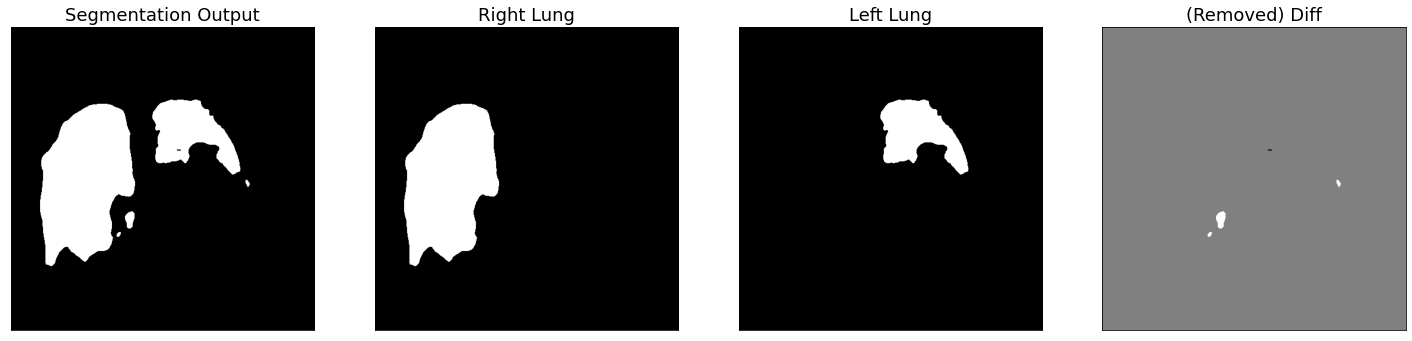

In [70]:
mask_separator(random.choice(masks), debug=True)

### Example:

as a nice side effect this removes holes in the segmentation... cool

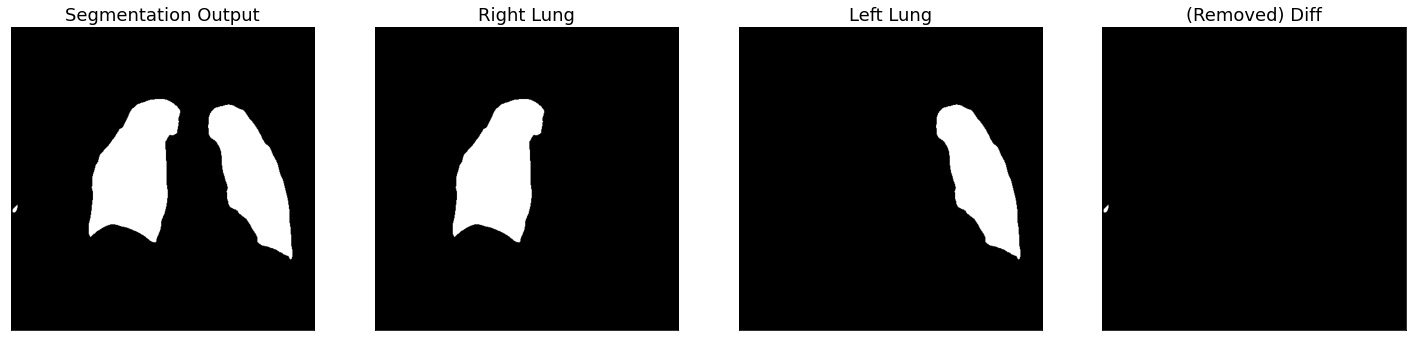

In [72]:
mask_separator("/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A027284/01-03-1901-NA-CHEST AP PORT-22190/1.000000-AP-20028/1-1_mask.png")

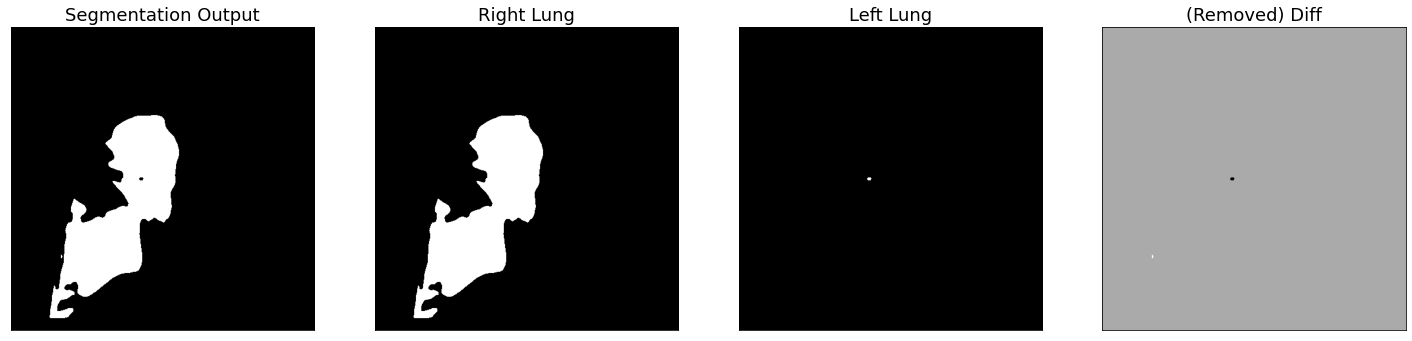

In [7]:
# What happens with one big mask? TBD!
## somehow i do net get this mask reproduced

mask_separator("/Volumes/Samsung_T5/MA/manifest-1638522923319/segmented_sample/A000801/01-03-1901-NA-CHEST AP PORT-62879/1.000000-AP-12195/1-1_mask.png")

## Tune Segmentation with traditional ImageOps

Since we are having huge discrepancies between the xrays we got and the ones that the NN is trained for, we try enhancing strategies to improve segmentation results.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.segmentation import segmentation
from src.segmentation.models import PretrainedUNet
import torch, torchvision
torch.manual_seed(42)
from pydicom import dcmread
from PIL import Image

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Torch device: ", device)

## Prepare U-Net
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)

## Load pre-learnt
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(f"models/lung_seg/{model_name}", map_location=torch.device("cpu")))
unet.to(device)
print("") #omit load_state_dict output

#in_images, out_images = segmentation.process_dcim(batch, unet, device)



Torch device:  cpu



In [2]:
# fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/segmented_sample/A000801/01-03-1901-NA-CHEST AP PORT-62879/1.000000-AP-12195/1-1.dcm"
# dcm = dcmread(fpath)
# origin = dcm.pixel_array
# origin = np.round(origin/origin.max()*255) #scale between [0,1]
# origin = Image.fromarray(origin).convert("P")

def infer_and_plot(origin):
    print("input array: ", np.min(np.array(origin)), np.max(np.array(origin)))
    origin = torchvision.transforms.functional.resize(origin, (512, 512))
    origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
    print("tensor: ", torch.min(origin), torch.max(origin))

    with torch.no_grad():
                origin = torch.stack([origin])
                origin = origin.to(device)
                out = unet(origin)
                softmax = torch.nn.functional.log_softmax(out, dim=1)
                out = torch.argmax(softmax, dim=1)
                
                origin = origin[0].to("cpu")  # back to [0,1]
                out = out[0].to("cpu")

    img = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
    mask =  torchvision.transforms.functional.to_pil_image(torch.cat([
        torch.zeros_like(origin),
        torch.stack([out.float()]),
        torch.zeros_like(origin)
    ]))

    fig, ax = plt.subplots(1, 3,
     figsize=(14,7)
    )
    ax[0].imshow(img)
    ax[1].imshow(Image.blend(img, mask, 0.2))
    ax[2].imshow(mask)

0 255
tensor(0.) tensor(1.)
input array:  0 255
tensor:  tensor(-0.5000) tensor(0.5000)


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


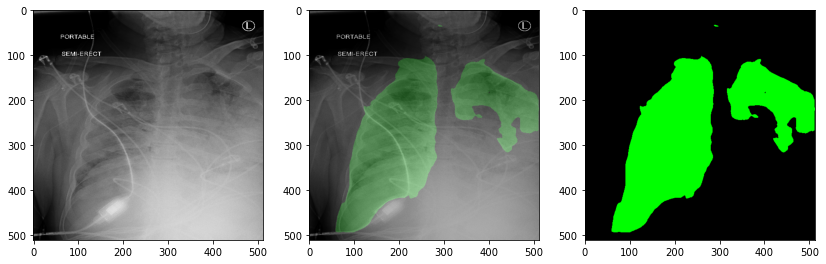

In [3]:
#fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A027284/11-04-1900-NA-CHEST AP PORT-69465/1.000000-AP-91718/1-1.dcm"
fpath="/Volumes/Samsung_T5/MA/manifest-1638522923319/segmented_sample/A000801/01-03-1901-NA-CHEST AP PORT-62879/1.000000-AP-12195/1-1.dcm"
dcm = dcmread(fpath)

origin = dcm.pixel_array
origin = np.round(origin/origin.max()*255) #scale between [0,1]
origin = Image.fromarray(origin).convert("P")
print(np.min(np.array(origin)), np.max(np.array(origin)))

foo = torchvision.transforms.functional.to_tensor(origin)
print(torch.min(foo), torch.max(foo))

infer_and_plot(origin)

input array:  0 255
tensor:  tensor(-0.5000) tensor(0.5000)


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


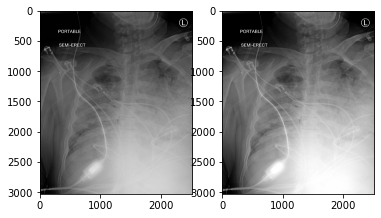

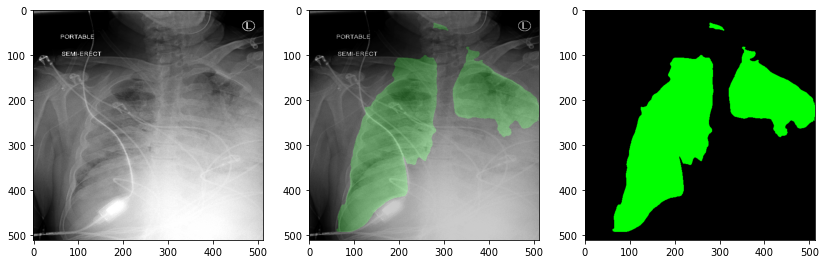

In [4]:
from skimage import exposure

#fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/segmented_sample/A000801/01-03-1901-NA-CHEST AP PORT-62879/1.000000-AP-12195/1-1.dcm"
#fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A027284/01-03-1901-NA-CHEST AP PORT-22190/1.000000-AP-20028/1-1.dcm"

dcm = dcmread(fpath)

origin = dcm.pixel_array
origin = np.round(origin/origin.max()*255) #scale between [0,1]
#origin = Image.fromarray(origin).convert("P")


# Contrast stretching
p2, p98 = np.percentile(origin, (2, 98))
img_rescale = exposure.rescale_intensity(origin, in_range=(p2, p98))
img_rescale = Image.fromarray(np.round(img_rescale/img_rescale.max()*255)).convert("P")
fig, ax = plt.subplots(1,2)

ax[0].imshow(origin, cmap="gray")
ax[1].imshow(img_rescale, cmap="gray")
infer_and_plot(img_rescale)


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: UserWarning: Possible precision loss converting image of type int16 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/skimage/util/dtype.py:525: UserWarning: Downcasting int16 to uint8 without scaling because max value 255 fits in uint8
  return _convert(image, np.uint8, force_copy)


input array:  2 255
tensor:  tensor(-0.4922) tensor(0.5000)


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


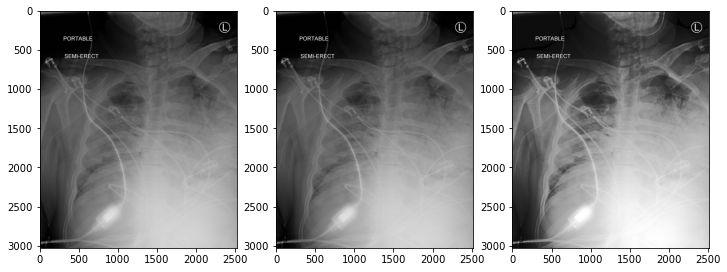

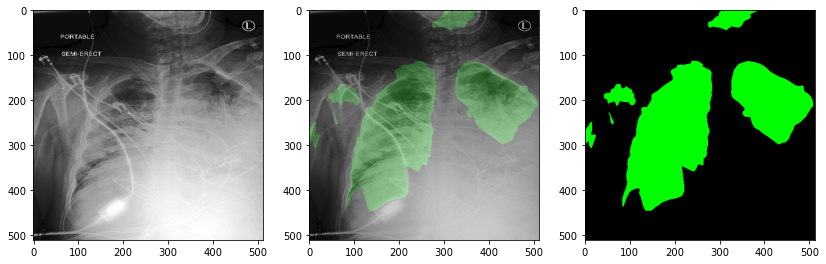

In [15]:
from skimage import exposure
from skimage.filters.rank import median

#fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/segmented_sample/A000801/01-03-1901-NA-CHEST AP PORT-62879/1.000000-AP-12195/1-1.dcm"
#fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A027284/01-03-1901-NA-CHEST AP PORT-22190/1.000000-AP-20028/1-1.dcm"

dcm = dcmread(fpath)

fig, ax = plt.subplots(1,3, figsize=(12,6))
origin = dcm.pixel_array

origin = dcm.pixel_array
origin = np.round(origin/origin.max() * 255)
ax[0].imshow(origin, cmap="gray")


origin = origin.astype(np.int16)
#ax[1].imshow(origin, cmap="gray")
#origin = Image.fromarray(origin).convert("P")


# Equalization
img_eq = median(origin)
ax[1].imshow(img_eq, cmap="gray")

img_eq = exposure.equalize_hist(img_eq)
img_eq = Image.fromarray(np.round(img_eq*255)).convert("P")

ax[2].imshow(img_eq, cmap="gray")
infer_and_plot(img_eq)




0 255
0.0 1.0
input array:  0 255
tensor:  tensor(-0.4961) tensor(0.5000)


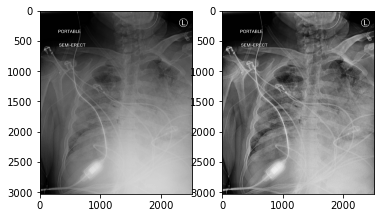

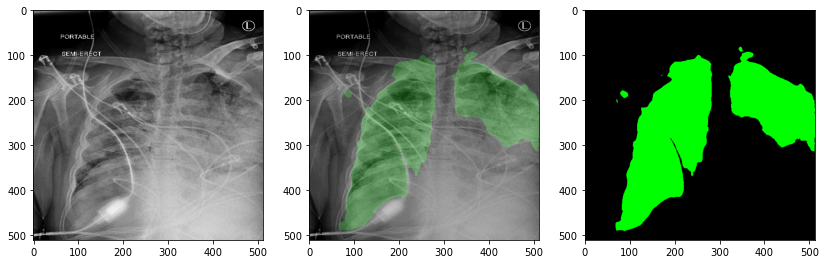

In [13]:
from skimage import exposure

#fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/segmented_sample/A000801/01-03-1901-NA-CHEST AP PORT-62879/1.000000-AP-12195/1-1.dcm"
#fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A027284/01-03-1901-NA-CHEST AP PORT-22190/1.000000-AP-20028/1-1.dcm"

dcm = dcmread(fpath)

fig, ax = plt.subplots(1,2)

origin = dcm.pixel_array
origin = np.round(origin/origin.max() * 255) #scale between [0,255]
origin = origin.astype(np.int16)
#origin = Image.fromarray(origin).convert("P")
ax[0].imshow(origin, cmap="gray")

print(np.min(origin), np.max(origin))

# Equalization
img_eq = exposure.equalize_adapthist(origin)
print(np.min(img_eq), np.max(img_eq))

#img_eq = img_eq + 0.5
img_eq = Image.fromarray(np.round(img_eq*255)).convert("P")

ax[1].imshow(img_eq, cmap="gray")
infer_and_plot(img_eq)




0 254
0.0 1.0
input array:  0 255
tensor:  tensor(-0.5000) tensor(0.5000)


/Users/ostritze/opt/anaconda3/envs/thesis-py3.7/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


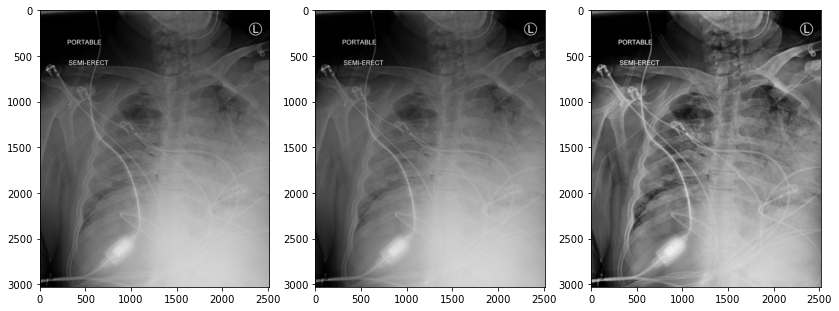

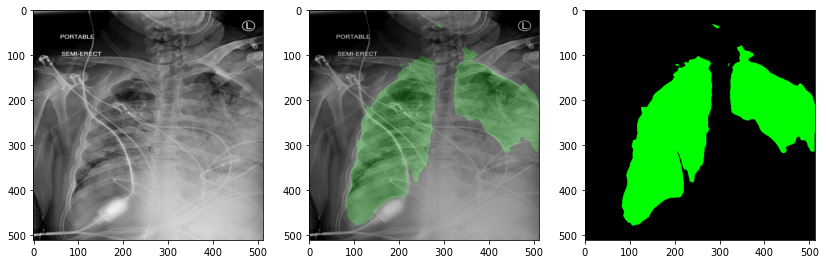

In [36]:
from skimage import exposure
from skimage.filters import gaussian

#fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/segmented_sample/A000801/01-03-1901-NA-CHEST AP PORT-62879/1.000000-AP-12195/1-1.dcm"
#fpath = "/Volumes/Samsung_T5/MA/manifest-1638522923319/subsample/A027284/01-03-1901-NA-CHEST AP PORT-22190/1.000000-AP-20028/1-1.dcm"

dcm = dcmread(fpath)

fig, ax = plt.subplots(1,3, figsize=(14,7))

origin = dcm.pixel_array
origin = origin/origin.max() #scale between [0,255]
ax[0].imshow(origin, cmap="gray")
origin = np.round(gaussian(origin, sigma=1.5) * 255)
origin = origin.astype(np.int16)
#origin = Image.fromarray(origin).convert("P")
ax[1].imshow(origin, cmap="gray")

print(np.min(origin), np.max(origin))

# Equalization
img_eq = exposure.equalize_adapthist(origin)
print(np.min(img_eq), np.max(img_eq))

#img_eq = img_eq + 0.5
img_eq = Image.fromarray(np.round(img_eq*255)).convert("P")

ax[2].imshow(img_eq, cmap="gray")
infer_and_plot(img_eq)


